In [239]:
import fnmatch
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skmob
from shapely.geometry import Point
from skmob.tessellation import tilers
import time
from utils.config import Config
from zipfile import ZipFile

In [2]:
dataset_file = "data/BikeNYC/BikeNYC.zip"

## Reading the NYC dataset
### From 1st April to 30th September

In [3]:
if dataset_file.endswith('.zip'):
    with ZipFile(dataset_file) as zipfiles:
        file_list = zipfiles.namelist()
        
        #get only the csv files
        csv_files = fnmatch.filter(file_list, "*.csv")
        
        #iterate with a list comprehension to get the individual dataframes
        data = [pd.read_csv(zipfiles.open(file_name)) for file_name in csv_files]
        df = pd.concat(data)
else:
    df = pd.read_csv(dataset_file, sep=',')

In [4]:
df.head()


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,558,2014-04-01 00:00:07,2014-04-01 00:09:25,82,St James Pl & Pearl St,40.711174,-74.000165,2008,Little West St & 1 Pl,40.705693,-74.016777,21062,Subscriber,1982,1
1,882,2014-04-01 00:00:20,2014-04-01 00:15:02,349,Rivington St & Ridge St,40.718502,-73.983299,312,Allen St & E Houston St,40.722055,-73.989111,20229,Subscriber,1988,1
2,587,2014-04-01 00:00:25,2014-04-01 00:10:12,293,Lafayette St & E 8 St,40.730287,-73.990765,334,W 20 St & 7 Ave,40.742388,-73.997262,20922,Subscriber,1959,1
3,355,2014-04-01 00:00:44,2014-04-01 00:06:39,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,282,Kent Ave & S 11 St,40.708273,-73.968341,20914,Subscriber,1981,1
4,524,2014-04-01 00:01:29,2014-04-01 00:10:13,459,W 20 St & 11 Ave,40.746745,-74.007756,503,E 20 St & Park Ave,40.738274,-73.987520,21051,Subscriber,1964,1


In [5]:
len(df)

5359995

## Getting the tessellation

In [6]:
tile_size = 500

In [7]:
tessellation = tilers.tiler.get("squared", base_shape="Manhattan, New York City, USA", meters=tile_size)

In [270]:
from operator import itemgetter
# tessellation['position'] contains che position in a matrix
# The origin is located on the bottom left corner
# We need to locate it on the top left corner
list_positions = [np.array(el) for el in tessellation['position']]
list_positions = np.array(sorted(list_positions,key=itemgetter(1)))
max_x = list_positions[:, 0].max()
max_y = list_positions[:, 1].max()

pos_set = set()
new_value = max_y +1
for i, pos in enumerate(list_positions[:, 1]):
    if pos not in pos_set:
        new_value -= 1
        pos_set.add(pos)
    list_positions[i, 1] = new_value
    
tessellation['positions'] = list(sorted(list_positions, key=itemgetter(0)))

In [272]:
tessellation.head()

,tile_ID,geometry,position,positions
0,0,"POLYGON ((-74.04722 40.68735, -74.04722 40.690...","[0, 1]","[0, 56]"
1,1,"POLYGON ((-74.04722 40.69075, -74.04722 40.694...","[0, 2]","[0, 55]"
2,2,"POLYGON ((-74.04273 40.69756, -74.04273 40.700...","[1, 4]","[1, 54]"
3,3,"POLYGON ((-74.02926 40.68394, -74.02926 40.687...","[4, 0]","[4, 57]"
4,4,"POLYGON ((-74.02926 40.68735, -74.02926 40.690...","[4, 1]","[4, 56]"


In [273]:
skmob.utils.plot.plot_gdf(tessellation, popup_features=['tile_ID', 'positions'])

## Filtering the dataset using the relevant features

In [10]:
df = df[['starttime', 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude', 'stoptime', 'bikeid']]

In [11]:
df_in = df[['starttime', 'start station latitude', 'start station longitude', 'bikeid']]
df_out = df[['end station latitude', 'end station longitude', 'stoptime', 'bikeid']]

In [25]:
ts = time.time()
gdf_in = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['start station longitude'], df['start station latitude']))
gdf_in_join = gpd.sjoin(gdf_in, tessellation)
gdf_in_join = gdf_in_join[['starttime',	'end station latitude', 'end station longitude', 'stoptime', 'bikeid', 'tile_ID', 'positions']]
time.time() - ts

615.395042181015

In [26]:
gdf_in_join.head()

,starttime,start station latitude,start station longitude,end station latitude,end station longitude,stoptime,bikeid,geometry,index_right,tile_ID,position,positions
0,2014-04-01 00:00:07,40.711174,-74.000165,40.705693,-74.016777,2014-04-01 00:09:25,21062,POINT (-74.00017 40.71117),75,75,"[10, 7]","[23, 7]"
1941,2014-04-01 07:54:29,40.711174,-74.000165,40.720664,-73.985180,2014-04-01 08:06:01,17294,POINT (-74.00017 40.71117),75,75,"[10, 7]","[23, 7]"
2511,2014-04-01 08:14:29,40.711174,-74.000165,40.701221,-74.012342,2014-04-01 08:22:24,16826,POINT (-74.00017 40.71117),75,75,"[10, 7]","[23, 7]"
3147,2014-04-01 08:33:01,40.711174,-74.000165,40.721816,-73.997203,2014-04-01 08:45:04,15512,POINT (-74.00017 40.71117),75,75,"[10, 7]","[23, 7]"
3318,2014-04-01 08:36:27,40.711174,-74.000165,40.692463,-73.989639,2014-04-01 08:52:46,16535,POINT (-74.00017 40.71117),75,75,"[10, 7]","[23, 7]"


In [28]:
ts = time.time()
gdf_final = gpd.GeoDataFrame(gdf_in_join, geometry=gpd.points_from_xy(gdf_in_join['end station longitude'], gdf_in_join['end station latitude']))
gdf_final_join = gpd.sjoin(gdf_final, tessellation)
gdf_final_join = gdf_final_join[['starttime', 'stoptime', 'bikeid', 'tile_ID_left', 'positions_left', 'tile_ID_right', 'positions_right']]
time.time() - ts


672.3460454940796

In [36]:
gdf_final_join = gdf_final_join.rename(columns={"tile_ID_left": "tile_ID_origin", "positions_left": "origin", "tile_ID_right": "tile_ID_destination", "positions_right": "destination"})
gdf_final_join['starttime'] = pd.to_datetime(gdf_final_join['starttime'])
gdf_final_join = gdf_final_join.sort_values(by='starttime')

,starttime,stoptime,bikeid,tile_ID_left,positions_left,tile_ID_right,positions_right
0,2014-04-01 00:00:07,2014-04-01 00:09:25,21062,75,"[23, 7]",12,"[27, 6]"
1,2014-04-01 00:00:20,2014-04-01 00:15:02,20229,163,"[19, 10]",118,"[21, 11]"
2,2014-04-01 00:00:25,2014-04-01 00:10:12,20922,120,"[21, 13]",104,"[22, 17]"
4,2014-04-01 00:01:29,2014-04-01 00:10:13,21051,49,"[25, 18]",144,"[20, 15]"
5,2014-04-01 00:01:53,2014-04-01 00:06:54,17286,229,"[17, 23]",176,"[19, 23]"
...,...,...,...,...,...,...,...
953882,2014-09-30 23:58:42,10/1/2014 00:15:13,17412,99,"[22, 12]",189,"[18, 10]"
953883,2014-09-30 23:59:13,10/1/2014 00:15:43,15249,106,"[22, 19]",142,"[20, 13]"
953884,2014-09-30 23:59:29,10/1/2014 00:07:46,16236,75,"[23, 7]",12,"[27, 6]"
953885,2014-09-30 23:59:58,10/1/2014 00:07:17,15271,129,"[21, 22]",198,"[18, 19]"


In [42]:
gdf_final_join

,starttime,stoptime,bikeid,tile_ID_origin,origin,tile_ID_destination,destination
0,2014-04-01 00:00:07,2014-04-01 00:09:25,21062,75,"[23, 7]",12,"[27, 6]"
1,2014-04-01 00:00:20,2014-04-01 00:15:02,20229,163,"[19, 10]",118,"[21, 11]"
2,2014-04-01 00:00:25,2014-04-01 00:10:12,20922,120,"[21, 13]",104,"[22, 17]"
4,2014-04-01 00:01:29,2014-04-01 00:10:13,21051,49,"[25, 18]",144,"[20, 15]"
5,2014-04-01 00:01:53,2014-04-01 00:06:54,17286,229,"[17, 23]",176,"[19, 23]"
...,...,...,...,...,...,...,...
953882,2014-09-30 23:58:42,10/1/2014 00:15:13,17412,99,"[22, 12]",189,"[18, 10]"
953883,2014-09-30 23:59:13,10/1/2014 00:15:43,15249,106,"[22, 19]",142,"[20, 13]"
953884,2014-09-30 23:59:29,10/1/2014 00:07:46,16236,75,"[23, 7]",12,"[27, 6]"
953885,2014-09-30 23:59:58,10/1/2014 00:07:17,15271,129,"[21, 22]",198,"[18, 19]"


In [30]:
len(gdf_final_join)

4847278

## Grouping by time

In [43]:
sample_time = '60min'

In [61]:
gdf_final_join['flow'] = 1
gdf = gdf_final_join[['starttime', 'tile_ID_origin', 'tile_ID_destination', 'flow']]

In [65]:
gdf_grouped = gdf.groupby([pd.Grouper(key='starttime', freq=sample_time), 'tile_ID_origin','tile_ID_destination']).sum()

In [275]:
matrix_mapping = {el[0]:el[1] for el in zip(tessellation['tile_ID'], tessellation['positions'])}

In [405]:
def f(row, matrix_mapping, X_dataset, timestamps):
    (t, o, d), f = row.name, row.flow       # time, origin, destination, flow
    if t not in timestamps:
        timestamps.add(t)
    time_idx = len(timestamps)-1
    # print(time_idx, f)
    x_out, y_out = matrix_mapping[str(o)]
    x_in, y_in = matrix_mapping[str(d)]

    X_dataset[time_idx][x_in][y_in][0] += f     # Inflow
    X_dataset[time_idx][x_out][y_out][1] += f   # Outflow

flows = 2
n_timestamps = gdf.groupby([pd.Grouper(key='starttime', freq=sample_time)]).ngroups # It can be done also by counting the days*24 
matrix_shape = (n_timestamps, max_x+1, max_y+1, flows)
X_dataset = np.zeros(matrix_shape)
timestamps = set()

gdf_grouped.apply(lambda row: f(row, matrix_mapping, X_dataset, timestamps), axis=1)
X_dataset.shape

(4392, 32, 58, 2)

In [406]:
def remove_empty_rows(X_dataset, flows):
    X_new = []
    X_sum = []
    for i in range(flows):
        X_new.append(X_dataset[:,:,:,i])
        X_sum.append(np.add.reduce(X_new[i]))

        X_new[i] = X_new[i][:,~(X_sum[i]==0).all(1)]    # Removing empty rows
        X_new[i] = X_new[i][:,:,~(X_sum[i].T==0).all(1)]    # Removing empty columns

    X_dataset = np.empty([X_dataset.shape[0], X_new[0].shape[1], X_new[0].shape[2], flows])

    for i in range(flows):
        X_dataset[:,:,:,i] = X_new[i]

    return X_dataset

In [431]:
X = remove_empty_rows(X_dataset, 2)

In [408]:
gdf.groupby([pd.Grouper(key='starttime', freq=sample_time)]).sum()

,flow
starttime,
2014-04-01 00:00:00,91
2014-04-01 01:00:00,37
2014-04-01 02:00:00,26
2014-04-01 03:00:00,11
2014-04-01 04:00:00,34
...,...
2014-09-30 19:00:00,2298
2014-09-30 20:00:00,1485
2014-09-30 21:00:00,1024


In [410]:
X_dataset[0,:,:,1].sum()

91.0

In [409]:
gdf_grouped[:100]

flow
starttime           tile_ID_origin tile_ID_destination      
2014-04-01 00:00:00 100            121                     1
                    102            60                      1
                    103            105                     1
                    104            119                     1
                                   166                     1
...                                                      ...
2014-04-01 01:00:00 123            81                      1
                    124            167                     1
                    147            101                     1
                    148            127                     1
                    149            126                     1

[100 rows x 1 columns]

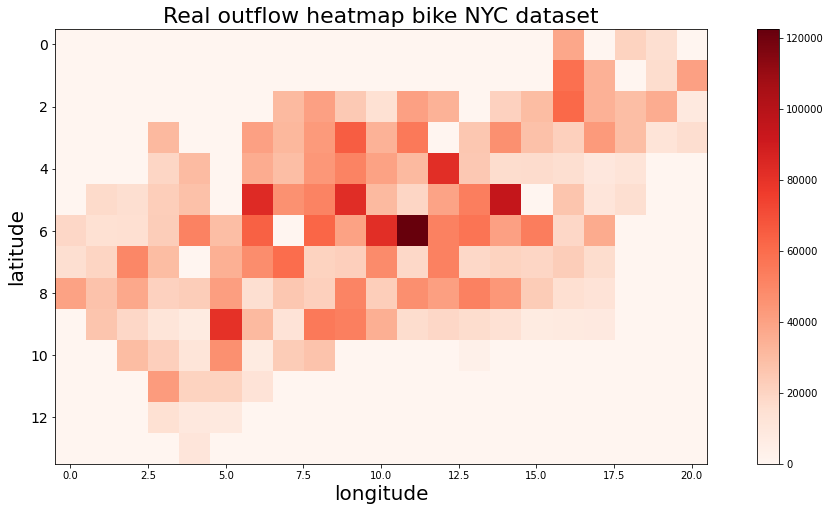

In [370]:
flow = 0
f = plt.figure(figsize=(18,8))
ax = f.add_subplot(1,1,1)
plt.ylabel('latitude',fontsize=20)
plt.xlabel('longitude',fontsize=20)
plt.yticks(fontsize=14)
plt.title("Real outflow heatmap bike NYC dataset", fontsize=22)
heatmap = X[0, :, :, flow]
for img in X[1:]:
    heatmap += img[:, :, flow]
plt.imshow(heatmap, cmap='Reds', interpolation='nearest')
plt.colorbar()
plt.show()

In [432]:
from utils.config import Config
from utils.load_datasets import save_stdata
DATAPATH = Config().DATAPATH
sample_time = '60min'
tile_size = 500
filename_df = "MANHATTAN__SIZE"+str(tile_size)+"_TIME_"+sample_time+"_df.h5"

In [433]:
time_string = [str(int(str(time_sample).replace("-", "").replace(" ","").replace(":", "")[:10])+1).encode('utf-8') for time_sample in timestamps]

In [434]:
time_string.sort()

In [435]:
save_stdata(os.path.join(DATAPATH, 'BikeNYC',filename_df), X, time_string)

## Load and evaluation of the trained model

In [421]:
def build_model(external_dim, map_height=16, map_width=8):
    c_conf = (len_closeness, nb_flow, map_height,
              map_width) if len_closeness > 0 else None
    p_conf = (len_period, nb_flow, map_height,
              map_width) if len_period > 0 else None
    t_conf = (len_trend, nb_flow, map_height,
              map_width) if len_trend > 0 else None

    model = stresnet(c_conf=c_conf, p_conf=p_conf, t_conf=t_conf,
                     external_dim=external_dim, nb_residual_unit=nb_residual_unit)
    adam = Adam(lr=lr)
    model.compile(loss='mse', optimizer=adam, metrics=[metrics.rmse])
    model.summary()
    # from keras.utils.visualize_util import plot
    # plot(model, to_file='model.png', show_shapes=True)
    return model

In [437]:
from utils.cache import save_matrix_in_cache, read_matrix_from_cache
from models.deepst.STResNet import stresnet
from keras.optimizers import Adam
import utils.metrics as metrics

In [448]:
preprocessing_file = "NYC"+str(tile_size)+sample_time+"_scaler"
matrix_file = "NYC"+str(tile_size)+sample_time+"_matrix.h5"

In [439]:
X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test = read_matrix_from_cache(matrix_file, preprocessing_file)

In [442]:
nb_epoch = 500  # number of epoch at training stage
batch_size = 32  # batch size
T = 24  # number of time intervals at a day
lr = 0.0002  # learning rate
len_closeness = 3  # length of closeness dependent sequence
len_period = 1  # length of peroid dependent sequence
len_trend = 1  # length of trend dependent sequence
nb_flow = 2

nb_residual_unit = 4  # number of residual units

In [443]:
model = build_model(external_dim, np.shape(X_train[0])[1], np.shape(X_train[0])[2])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 21, 6)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 14, 21, 2)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 14, 21, 2)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 21, 64)   3520        input_1[0][0]                    
_______________________________________________________________________________________

In [444]:
path_model = 'temp/MODEL'
hyperparams_name = 'Tile{}.freq{}.c{}.p{}.t{}.resunit{}.lr{}.bs{}'.format(
        tile_size, sample_time, len_closeness, len_period, len_trend, nb_residual_unit, lr, batch_size)
fname_param = os.path.join(path_model, '{}.h5'.format(hyperparams_name))

In [445]:
model.load_weights(fname_param)

In [446]:
import pickle 
def load_obj(file_path):
    with open(file_path + '.pkl', 'rb') as f:
        return pickle.load(f)

In [449]:
Y_pred = model.predict(X_test)

mmn = load_obj(preprocessing_file)

data = mmn.inverse_transform(Y_test)
data_pred = np.array(mmn.inverse_transform(Y_pred), dtype=int)

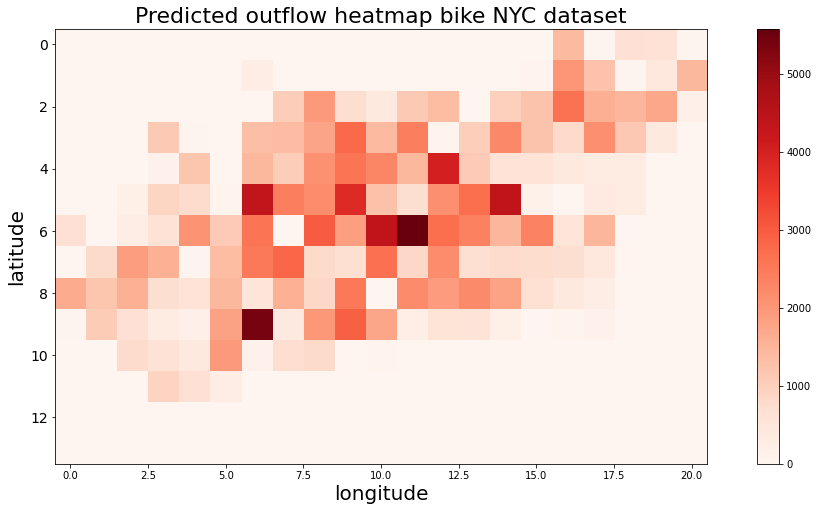

In [450]:
f = plt.figure(figsize=(18,8))
ax = f.add_subplot(1,1,1)
plt.ylabel('latitude',fontsize=20)
plt.xlabel('longitude',fontsize=20)
plt.yticks(fontsize=14)
plt.title("Predicted outflow heatmap bike NYC dataset", fontsize=22)
flow = 1
heatmap = data_pred[0, :, :, flow]
for img in data_pred[1:]:
    heatmap += img[:, :, flow]

plt.imshow(heatmap, cmap='Reds', interpolation='nearest')
plt.colorbar()
plt.show()

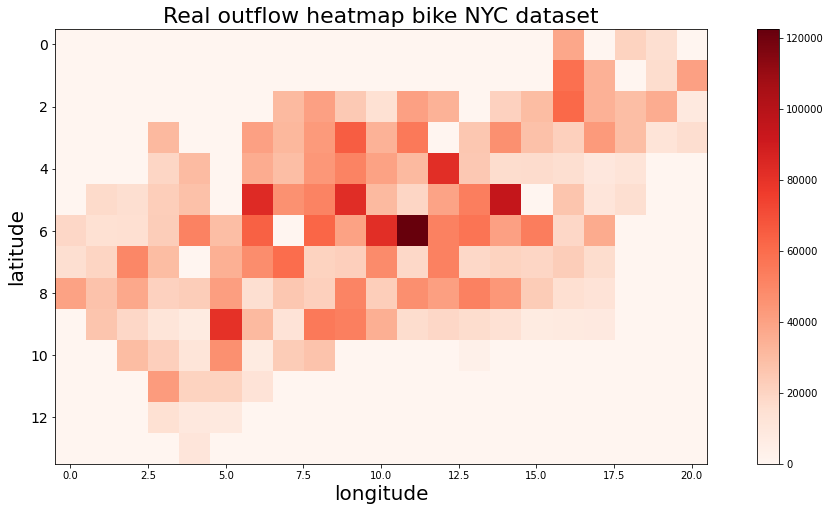

In [451]:
flow = 0
f = plt.figure(figsize=(18,8))
ax = f.add_subplot(1,1,1)
plt.ylabel('latitude',fontsize=20)
plt.xlabel('longitude',fontsize=20)
plt.yticks(fontsize=14)
plt.title("Real outflow heatmap bike NYC dataset", fontsize=22)
heatmap = X[0, :, :, flow]
for img in X[1:]:
    heatmap += img[:, :, flow]
plt.imshow(heatmap, cmap='Reds', interpolation='nearest')
plt.colorbar()
plt.show()